# Limb darkening removal from HMI SHARP CEA cutoffs

#### We are using http://articles.adsabs.harvard.edu/pdf/1977SoPh...51...25P as reference with equation 11 and following coeficients


0.32519, 1.26432, -1.44591, 1.55723, -0.87415, 0.173333

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits as pf
import os
import glob
# This makes nice big plots for matplotlib
import matplotlib as mpl
params = {'font.size': 14,
          'figure.figsize': (15.0, 8.0),
          'lines.linewidth': 2.,
          'lines.markersize': 15,
          'animation.embed_limit': 2048,
          }
mpl.rcParams.keys()
mpl.rcParams.update(params)
np.set_printoptions(suppress=True)

In [14]:
# Create array for holding limb darkening coef
# 6205.90 A
coef_limb_hmi = np.array(
    [0.32519, 1.26432, -1.44591, 1.55723, -0.87415, 0.173333])

# 6109.75 A
coef_limb_2 = np.array(
    [0.29397, 1.46821, -2.20076, 3.05295, -2.34756, 0.73318])

# Load data paths
data_dir_CEA = os.path.abspath(
    "/home/lazar/Fak(s)/AF/prakse/SDSA/data/3481_11923_SHARP_CEA")
data_list_CEA = sorted(glob.glob(os.path.join(data_dir_CEA, '*continuum*')))

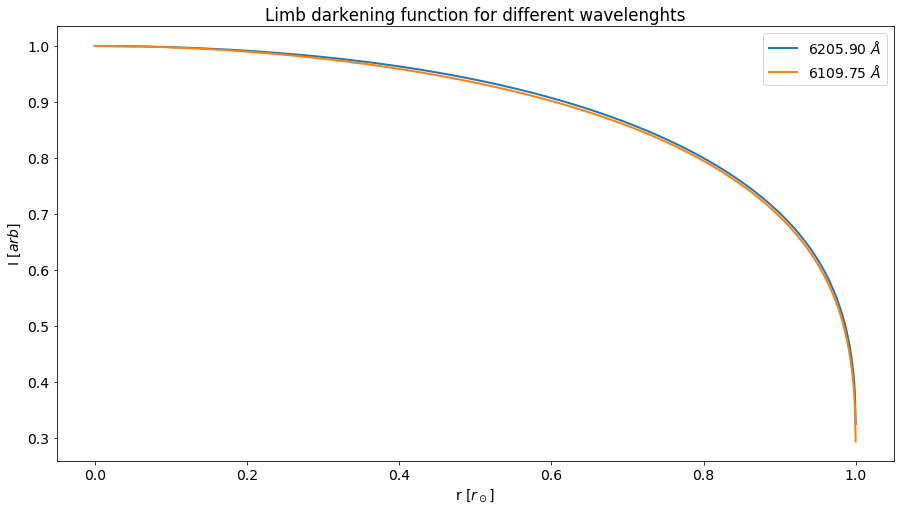

In [15]:
def limb_dark(r, koef=coef_limb_hmi):
    # r is normalized distance from center [0,1]
    if len(koef) != 6:
        raise ValueErrror("koef len should be exactly 6")
    if np.max(r) > 1 or np.min(r) < 0:
        raise ValueError("r should be in [0,1] range") 
    mu = np.sqrt(1-r**2) # mu = cos(theta)
    return koef[0]+koef[1]*mu+koef[2]*mu**2+koef[3]*mu**3+koef[4]*mu**4+koef[5]*mu**5

#ok, pitaj za ovo sutra, ali mislim da je ok

plt.figure(1)
plt.plot(np.linspace(0,1,1000),limb_dark(np.linspace(0,1,1000)), label=r'6205.90 $\AA$')
plt.plot(np.linspace(0,1,1000),limb_dark(np.linspace(0,1,1000), coef_limb_2), label=r'6109.75 $\AA$')
plt.legend(loc='best')
plt.xlabel(r'r $[r_\odot]$')
plt.ylabel(r'I $[arb]$')
plt.title('Limb darkening function for different wavelenghts')
plt.show()

### We have our limb darkening function ready, lets load data and correct it

In [16]:
filename_limb = data_list_CEA[0]
filename_cent = data_list_CEA[600]

#No actual need to use pf.open, we will use sunpy map
#But i've used limb_data[1].header for debugging and comparing

limb_data = pf.open(filename_limb)
limb_data.verify('silentfix')
#limb_data[1].header

#cent_data = pf.open(filename_cent)
#cent_data.verify('silentfix')

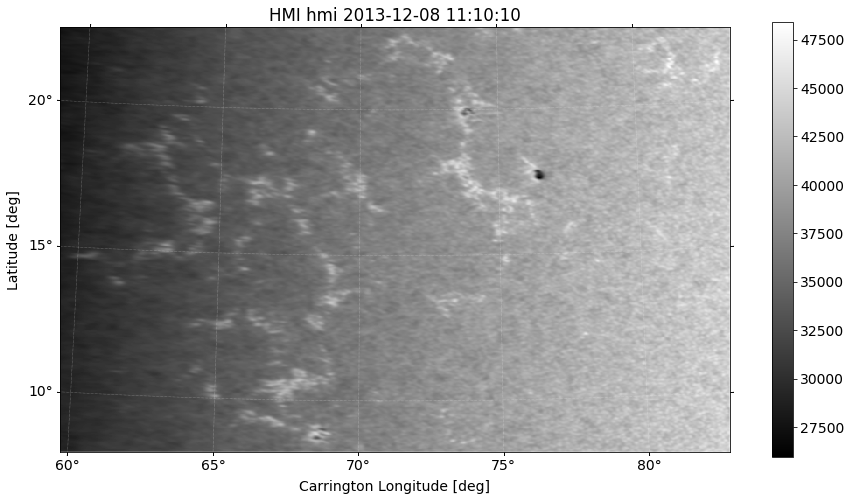

In [17]:
import sunpy.map
import sunpy.coordinates.transformations
from sunpy.coordinates import frames
import astropy.units as u

#Import fits file into sunpy.map object
limb = sunpy.map.Map(filename_limb)
#Quick plot preview of sunpy.map object
#Grid and colorbar are automatticly overploted because of extensive header information in fits file
#Also, hmi data is natively supported by sunpy
#ie hmi map is extension of native sunpy map
#https://docs.sunpy.org/en/stable/code_ref/map.html#map-sources
limb.peek()

#This returns coordinate vector for every pixel for limb map
#It calculates it using CRVAL, CRPIX .... keywords from header
#sunpy.map.all_coordinates_from_map(limb)


#This is where the magic starst
#It bassicaly uses transform_to method on above pixel coordinate map
#and converts it to specific frame
#in this case, helioprojective frame with observer location fetched from fits header file
#please note that some people say that HMI dont provide its true corrdinate
#ie for same timestamp, AIA and HMI reported coordinates are different
#see https://github.com/sunpy/sunpy/issues/3057
helioproj_limb = sunpy.map.all_coordinates_from_map(limb).transform_to(frames.Helioprojective(observer=limb.observer_coordinate))


#Extract radii of sun in arcseconds provided in fits header
rsun_hp_limb = limb.rsun_obs.value
#print(rsun_hp)

In [18]:
#Calculate distance to center of disk for every pixel
#based on helioprojected coordinates
#and normalized it with sun radii from header
#we need data in units of radii of sun, because of limb darkening function
distance_from_limb_limb = np.sqrt(helioproj_limb.Tx.value**2+helioproj_limb.Ty.value**2)/rsun_hp_limb


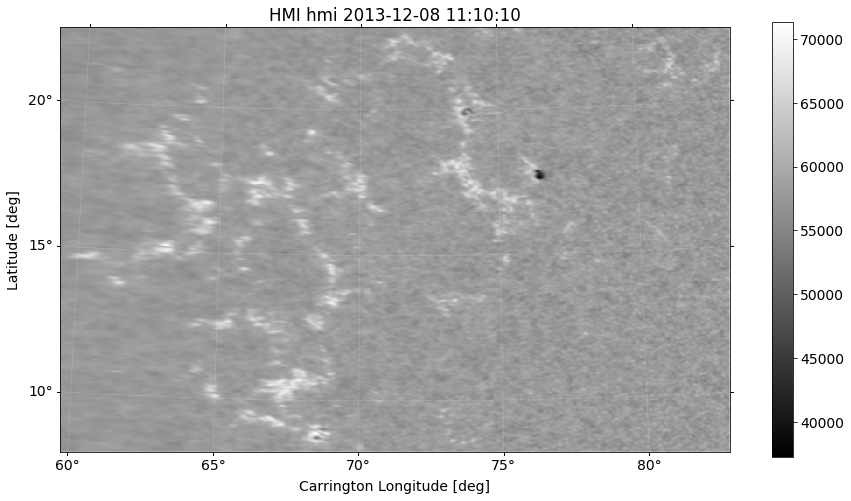

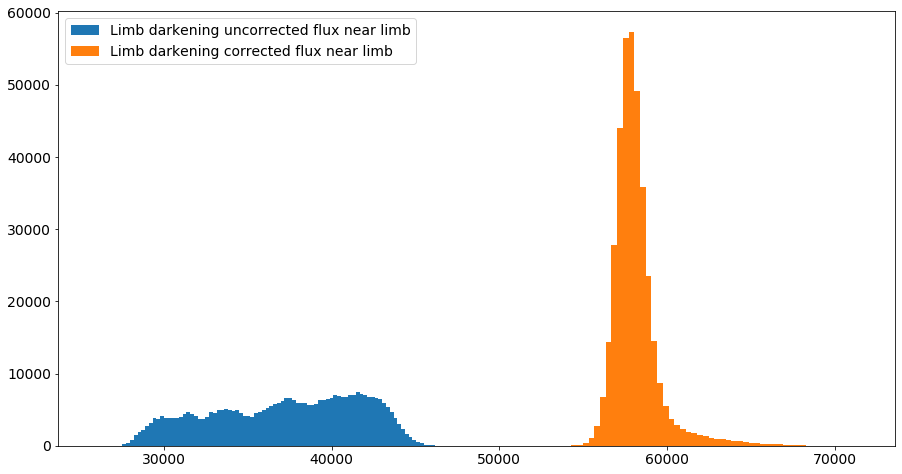

In [19]:
#Create matrix with data corrected for limb darkening
limb_cor_data = limb.data / limb_dark(distance_from_limb_limb)
#Create new sunpy map for corrected data 
#im using same header data, this could be problematic because average flux is changing because of correction
#but since we wont do anything that specific, i really dont care fixing that
limb_corrected = sunpy.map.Map(limb_cor_data, limb.meta)
#preview corrected map
limb_corrected.peek()

#Lets plot histograms of flux data between corrected and uncorrected data
plt.figure(1)
plt.hist(limb.data.flatten(), bins=100, label='Limb darkening uncorrected flux near limb')
plt.hist(limb_corrected.data.flatten(), bins=100, label='Limb darkening corrected flux near limb')
plt.legend(loc='best')
plt.show()


## Same procedure for near disk center data (comments from above still apply)

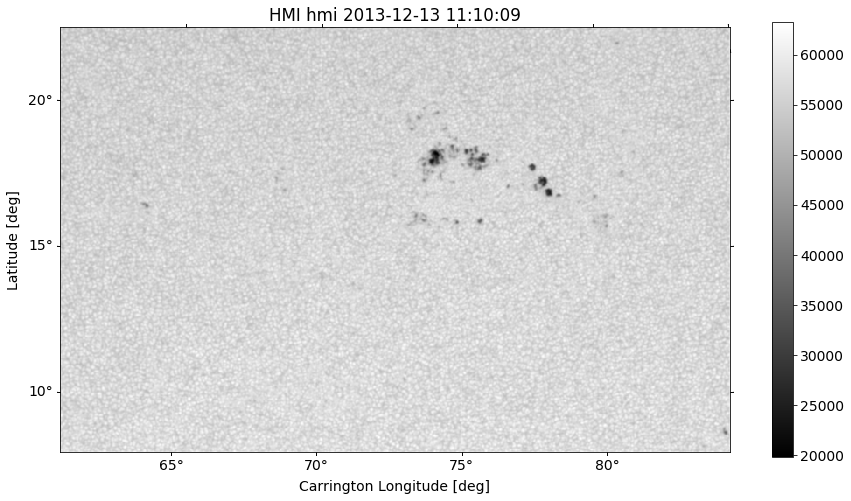

In [20]:
cent = sunpy.map.Map(filename_cent)
cent.peek()
helioproj_cent = sunpy.map.all_coordinates_from_map(cent).transform_to(frames.Helioprojective(observer=cent.observer_coordinate))
#print(helioproj_limb)
rsun_hp_cent = cent.rsun_obs.value
distance_from_limb_cent = np.sqrt(helioproj_cent.Tx.value**2+helioproj_cent.Ty.value**2)/rsun_hp_cent
#plt.hist(cent.data)
#plt.show()

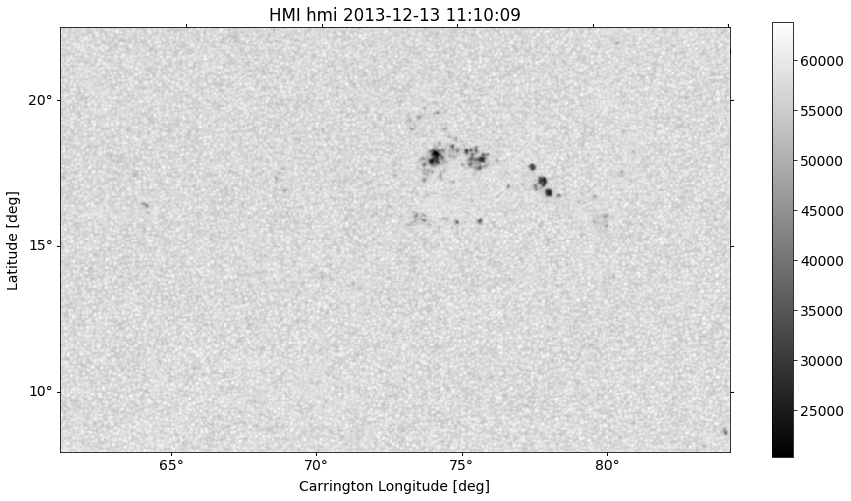

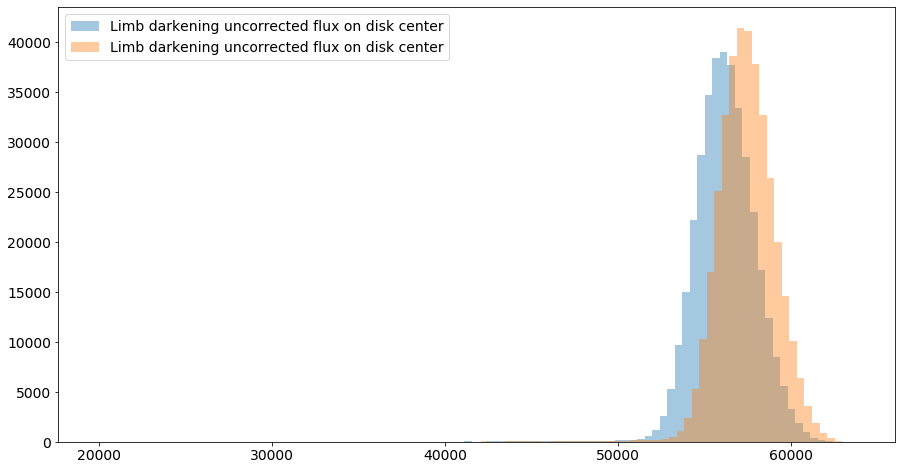

In [21]:
cent_cor_data = cent.data / limb_dark(distance_from_limb_cent)
cent_corrected = sunpy.map.Map(cent_cor_data, cent.meta)
cent_corrected.peek()
plt.hist(cent.data.flatten(), bins=100, alpha=0.4, label='Limb darkening uncorrected flux on disk center')
plt.hist(cent_corrected.data.flatten(), bins=100, alpha=0.4, label='Limb darkening uncorrected flux on disk center')
plt.legend(loc='best')
plt.show()

## Lets plot all histograms on one canvas

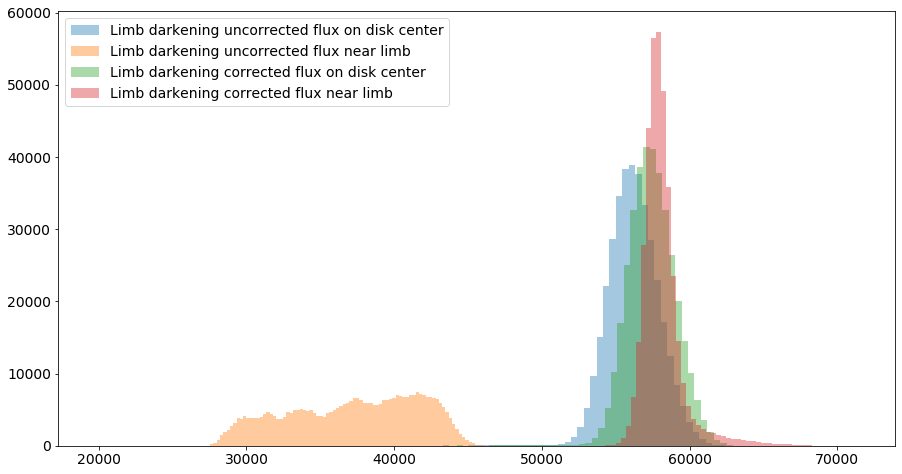

In [22]:
plt.figure(1)
plt.hist(cent.data.flatten(), bins=100, alpha=0.4, label='Limb darkening uncorrected flux on disk center')
plt.hist(limb.data.flatten(), bins=100, alpha=0.4, label='Limb darkening uncorrected flux near limb')
plt.hist(cent_corrected.data.flatten(), bins=100, alpha=0.4, label='Limb darkening corrected flux on disk center')
plt.hist(limb_corrected.data.flatten(), bins=100, alpha=0.4, label='Limb darkening corrected flux near limb')
plt.legend(loc='best')
plt.show()

# This is helper routine that you can use to show info about all fits keywords for your specific hmi series 

In [23]:
import drms
series = 'hmi.sharp_cea_720s'
c = drms.Client()

# Query series info
si = c.info(series)
print('Listing keywords for "%s":\n' % si.name)
for k in sorted(si.keywords.index):
    ki = si.keywords.loc[k]
    print(k)
    print('  type ....... %s ' % ki.type)
    print('  recscope ... %s ' % ki.recscope)
    print('  defval ..... %s ' % ki.defval)
    print('  units ...... %s ' % ki.units)
    print('  note ....... %s ' % ki.note)
    print()


Listing keywords for "hmi.sharp_cea_720s":

ABSNJZH
  type ....... float 
  recscope ... variable 
  defval ..... nan 
  units ...... (G^2)/m 
  note ....... Absolute value of the net current helicity 

AMBBTHR0
  type ....... double 
  recscope ... variable 
  defval ..... nan 
  units ...... G 
  note ....... Transverse field strength threshold at disk center for using simulated annealing 

AMBBTHR1
  type ....... double 
  recscope ... variable 
  defval ..... nan 
  units ...... G 
  note ....... Transverse field strength threshold at limb for using simulated annealing 

AMBCODEV
  type ....... string 
  recscope ... variable 
  defval .....  
  units ...... none 
  note ....... Version of Disambig code 

AMBDOCU
  type ....... string 
  recscope ... variable 
  defval .....  
  units ...... none 
  note ....... Document for Disambig code 

AMBGMTRY
  type ....... int 
  recscope ... variable 
  defval ..... -2147483648 
  units ...... none 
  note ....... Flag determining whether 